To celebrate figuring out [how to blog with jupyter notebooks](https://cduvallet.github.io/posts/2018/03/ipython-notebooks-jekyll), I'm going to go through some tricks I've learned to plot pretty boxplots in Python.

# Boxplots

Boxplots are my absolute favorite way to look at data, but the defaults in Python aren't publication-level pretty. When making boxplots, I think it's very important to also plot the underlying raw data points whenever that's possible. Especially for main text figures and/or in cases without that many points, this is the best way to simultaneously summarize the data and allow the reader to come to their interpretations of it. When I read a paper, I get fairly grumpy when I know that the sample size is low (say, less than 100) but I only get to see the boxplot. Just let me see the data - otherwise, I have to wonder if you're trying to hide something...

Anyway. In this post, we'll be using `seaborn` to establish the main boxplots, with some additional tweaking to make them beautiful. Of course, I didn't come up with these solutions all on my own, and deep gratitude goes to Stack Overflow for teaching me these tricks (in addition to almost everything else I know about coding). Unfortunately, I've been making these plots long enough that I go back and reference my own previous code, so I've lost links back to the most useful StackOverflow posts that have helped me along... :(

# Generate data

First, let's set up some toy data. Here, we'll be simulating making some measurements on three different body sites for 15 healthy patients and 10 diseased patients.

In [10]:
import pandas as pd
import numpy as np

# Set up the data
data = np.concatenate(
    [[np.random.normal(loc=1, size=15), 15*['site1'], 15*['healthy']],
     [np.random.normal(loc=3, size=15), 15*['site2'], 15*['healthy']],
     [np.random.normal(loc=0, size=15), 15*['site3'], 15*['healthy']],
     [np.random.normal(loc=1, size=10), 10*['site1'], 10*['disease']],
     [np.random.normal(loc=1, size=10), 10*['site2'], 10*['disease']],
     [np.random.normal(loc=3, size=10), 10*['site3'], 10*['disease']]], 
    axis=1)
df = pd.DataFrame(columns=['value', 'site', 'label'], data=data.T)
df['value'] = df['value'].astype(float)

# Show every ninth row
df.iloc[::9]

,value,site,label
0,2.591935,site1,healthy
9,1.823141,site1,healthy
18,2.876044,site2,healthy
27,5.003611,site2,healthy
36,-1.586702,site3,healthy
45,0.675445,site1,disease
54,0.460209,site1,disease
63,1.158567,site2,disease
72,1.226395,site3,disease


# Default boxplot with seaborn

The default seaborn plot isn't bad, but it also isn't great. I typically use a call to `boxplot` first and then `stripplot` to show the raw data. Note that doing this makes the legend wonky - I usually fix this afterwards (or, more often than not, deal with the legend separately).

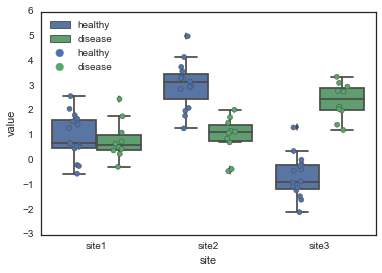

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.boxplot(x='site', y='value', hue='label', data=df)
sns.stripplot(x='site', y='value', hue='label', data=df, 
              jitter=True, split=True, linewidth=0.5)
plt.legend(loc='upper left')

The easiest way to improve these plots is to (1) change the seaborn style to `'white'` and (2) pass in a color palette that you like. Also note that when you plot both a boxplot and the raw points, you should tell seaborn not to plot any of the outliers with `fliersize=0`, otherwise you'll have double-points for these.

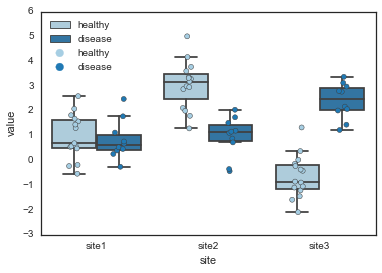

In [12]:
sns.set_style('white')

pal = sns.color_palette('Paired')

sns.boxplot(x='site', y='value', hue='label', data=df,
    palette=pal, fliersize=0)
sns.stripplot(x='site', y='value', hue='label', data=df, 
    jitter=True, split=True, linewidth=0.5, palette=pal)
plt.legend(loc='upper left')

Alternatively, you can explicitly specify the colors you want for each hue value.

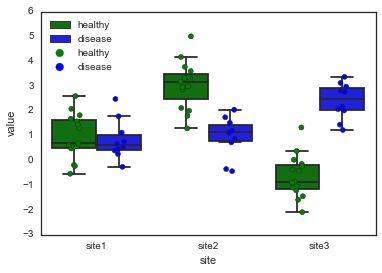

In [13]:
pal = {'healthy': 'green', 'disease': 'blue'}

sns.boxplot(x='site', y='value', hue='label', data=df,
    palette=pal, fliersize=0)
sns.stripplot(x='site', y='value', hue='label', data=df, 
    jitter=True, split=True, linewidth=0.5, palette=pal)
plt.legend(loc='upper left')

# More modifications

While convenient, this is also not beautiful enough to be publication-worthy. If we want to make really nice boxplots, we'll have to roll up our sleeves and get more into the details.

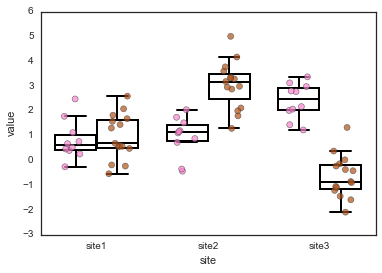

In [14]:
# When you start digging into the parameters, it's a good idea
# to explicitly initialize the figure and get the figure and
# axes handles
fig, ax = plt.subplots()

# First, we'll pick some nicer colors for the healthy and disease.
# I got these colors by tweaking some colors from the Set1 palette
# in powerpoint, and then grabbing the hex code from Powerpoint.
dark_brown = '#B25116'
dark_pink = '#FB84D1'
pal = {'healthy': dark_brown, 'disease': dark_pink}

# Here, we set up some properties for the boxplot parts. I definitely
# stole this from Stack Overflow, but I can't find the original post
# right now.
boxprops = {'edgecolor': 'k', 'linewidth': 2, 'facecolor': 'w'}
lineprops = {'color': 'k', 'linewidth': 2}

# Set up some general kwargs that we'll use in both the stripplot and boxplot
# Note that you can change the order of hue variables here.
kwargs = {'palette': pal, 'hue_order': ['disease', 'healthy']}

# The boxplot kwargs get passed to matplotlib's boxplot function.
# Note how we can re-use our lineprops dict to make sure all the lines
# match. You could also edit each line type (e.g. whiskers, caps, etc)
# separately. 
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75}, 
                      **kwargs)
stripplot_kwargs = dict({'linewidth': 0.6, 'size': 6, 'alpha': 0.7}, 
                        **kwargs)

# And we can plot just like last time
sns.boxplot(x='site', y='value', hue='label', data=df, ax=ax,
    fliersize=0, **boxplot_kwargs)
sns.stripplot(x='site', y='value', hue='label', data=df, ax=ax,
    split=True, jitter=0.2, **stripplot_kwargs)
ax.legend_.remove()

If we want, we can also play with the facecolors. We can also do this with a normal call through the `palette` keyword in the seaborn function:

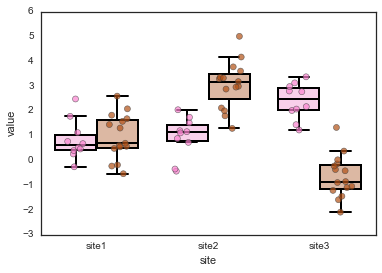

In [15]:
pal = {'healthy': dark_brown, 'disease': dark_pink}

# Set up another palette for the boxplots, with slightly lighter shades
light_pink = '#FFC9EC'
light_brown = '#E5B699'
face_pal = {'healthy': light_brown, 'disease': light_pink}

hue_order = ['disease', 'healthy']

# Make sure to remove the 'facecolor': 'w' property here, otherwise
# the palette gets overrided
boxprops = {'edgecolor': 'k', 'linewidth': 2}
lineprops = {'color': 'k', 'linewidth': 2}

boxplot_kwargs = {'boxprops': boxprops, 'medianprops': lineprops,
                  'whiskerprops': lineprops, 'capprops': lineprops,
                  'width': 0.75, 'palette': face_pal, 
                  'hue_order': hue_order} 

stripplot_kwargs = {'linewidth': 0.6, 'size': 6, 'alpha': 0.7,
                    'palette': pal, 'hue_order': hue_order}

# And we can plot just like last time
fig, ax = plt.subplots()
sns.boxplot(x='site', y='value', hue='label', data=df, ax=ax,
    fliersize=0, **boxplot_kwargs)
sns.stripplot(x='site', y='value', hue='label', data=df, ax=ax,
    split=True, jitter=0.2, **stripplot_kwargs)
ax.legend_.remove()

That looks pretty good (and is the version I ended up going with for my current manuscript), but what if you also want to change the line colors to match the hues? In this case, you need to go directly edit the artists after they're drawn.

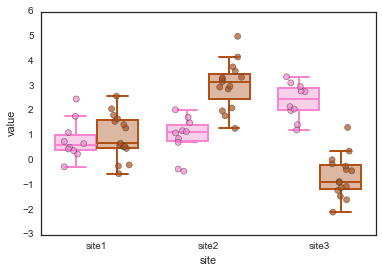

In [16]:
# Plot, using all the same parameters as above
fig, ax = plt.subplots()
sns.boxplot(x='site', y='value', hue='label', data=df, ax=ax,
    fliersize=0, **boxplot_kwargs)
sns.stripplot(x='site', y='value', hue='label', data=df, ax=ax,
    split=True, jitter=0.2, **stripplot_kwargs)
ax.legend_.remove()

for i, artist in enumerate(ax.artists):
    if i % 2 == 0:
        col = dark_pink
    else:
        col = dark_brown

    # This sets the color for the main box
    artist.set_edgecolor(col)
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# A few final notes...

So far, I've been removing the legend because of the annoying double-legend issue when you call both `sns.boxplot` and `sns.stripplot`. I haven't found a great way to get around this except the very manual way of going in afterwards and keeping only the first half of the legend:

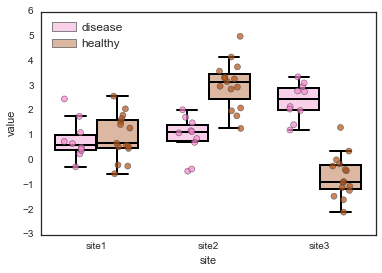

In [17]:
# Plot, using all the same parameters as above
fig, ax = plt.subplots()
sns.boxplot(x='site', y='value', hue='label', data=df, ax=ax,
    fliersize=0, **boxplot_kwargs)
sns.stripplot(x='site', y='value', hue='label', data=df, ax=ax,
    split=True, jitter=0.2, **stripplot_kwargs)

# Fix the legend, keep only the first two legend elements
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles[0:2], labels[0:2], 
               loc='upper left', 
               fontsize='large',
               handletextpad=0.5)
lgd.legendHandles[0]._sizes = [40]
lgd.legendHandles[1]._sizes = [40]

Also a note that you can change the width of the boxplot with the `width` parameter in the call to `sns.boxplot`. However, this doesn't change the width of each individual box, but rather the total width of each pair of boxes (or however many hues you have). So in the case where the data spans a similar range and the boxes are right next to each other (like in site 1, above), sometimes the box lines overlap slightly. If they're not black, then you can see this if you look closely. I haven't figured out a good way to fix this (and [it seems like](https://github.com/mwaskom/seaborn/issues/1076) maybe there might not be one).

And, finally, in this post I didn't go through and pretty up the axes labels but that's also something you need to do to make a figure publication-worthy. Add some capital letters, replace underscores with spaces, and make all font sizes quite large.